In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import plotly
import natsort
import plotly.graph_objects as go

In [2]:
os.getcwd()

'/Users/seanmascarenhas/Downloads'

In [3]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [4]:
import plotly.graph_objects as go


def chunks(lst, n):
    """ breaks the list of data into chunks of fixed size """
    return [lst[x:x + n] for x in range(0, len(lst), n)]


def perimeter(dia):
    """perimeter of grains"""
    return np.pi * dia

In [138]:
os.chdir('/Users/seanmascarenhas/Desktop/MoAu/MoAu2/850/20')

I need my program to read the file called total energy - it contains a count of the number of atoms that are in the grain boundary region.
This number divided by the total number of atoms in my system is my grain boundary fraction. 

I also need the program to read the final state step file as it contains the positional information of each atom as well as information on which grain the atoms belong to (it is possible to count the number of atoms in the grain boundary region through the final state file as well).

I need to count the number of atoms in each grain and then plot the information. Atoms having the same grain number in the final state file are atoms in the same grain. 

The number of atoms in each grain times the volume of the atoms, which is a fixed number, will give me the volume of a grain. The shape of a grain is approximated as a slice of a spherical grain. To account for that I will convert my grain volume to a surface area, dividing it by the height of the slice, and using this surface area to calculate the diameter of the grain. 

I will do this for each grain in the final state - then calculate the average value of grain size as well as the standard deviation, which will provide the error bar to my calculation. 

This average grain size, expressed as the diameter of the grain and nominally in nanometers, will be used along with the previously calculated grain boundary volume fraction to calculate the normalized grain boundary thickness. The shape factor in this calculation is either 2 or 3 and I will test both. 

This will be repeated on each combination of temperature and at. % solute, of which there are 18 and 30 respectively, providing 540 datapoints.  

* Count how many atoms have the same gid (which will give me the size)
* Find the average (the average number of atoms in a grain) and std deviation 
    - avg size (the diameter of the grain) is calculated from surface area of the grain 
    - take number of grains in the avg grain, divide by the thickness (**4**) then calculate the diameter (**d**)from A=π(d/2)^2 [each atom has a fixed area/volume]
* Add this data to a set of **avg grain sizes** whose x axis is **temperature** and y axis is **concentration** 
* Calculate **grain boundary fraction** (sum of ones in gbid column), add to **grain boundary fraction** set (_fgb_) [same x & y axis]
* Calculate **t** (the normalized grain boundary thickness) 
    - using _fgb_ =1-((t-d)/d)^D -> D is shape factor, use 2 & also 3 to compare
    - add this to the **t** set

*  Repeat the above - for each temperature and each at. %
* Display the values of t as a contour map - x axis being temperature, y axis being concentration. 


In [139]:
step=pd.read_csv('step100000.txt',delim_whitespace='True',skiprows=9,names=['x','y','z','cid','gid','gbid','nid'])
step.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440000 entries, 0 to 1439999
Data columns (total 7 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   x       1440000 non-null  float64
 1   y       1440000 non-null  float64
 2   z       1440000 non-null  float64
 3   cid     1440000 non-null  int64  
 4   gid     1440000 non-null  int64  
 5   gbid    1440000 non-null  int64  
 6   nid     1440000 non-null  int64  
dtypes: float64(3), int64(4)
memory usage: 76.9 MB


In [140]:
step.head()

,x,y,z,cid,gid,gbid,nid
0,0.0,0.0,0.0,0,9373,0,0
1,0.5,0.5,0.5,0,9373,0,2
2,0.0,0.0,1.0,0,9373,0,0
3,0.5,0.5,1.5,0,9373,0,2
4,0.0,1.0,0.0,0,9373,0,0


In [141]:
grains=step.loc[step.gbid==0]
grains

,x,y,z,cid,gid,gbid,nid
0,0.0,0.0,0.0,0,9373,0,0
1,0.5,0.5,0.5,0,9373,0,2
2,0.0,0.0,1.0,0,9373,0,0
3,0.5,0.5,1.5,0,9373,0,2
4,0.0,1.0,0.0,0,9373,0,0
...,...,...,...,...,...,...,...
1439995,599.5,598.5,1.5,0,9373,0,0
1439996,599.0,599.0,0.0,0,9373,0,0
1439997,599.5,599.5,0.5,0,9373,0,0
1439998,599.0,599.0,1.0,0,9373,0,0


In [142]:
grains2=grains[grains.duplicated(subset=['gid'],keep=False)]
grains2

,x,y,z,cid,gid,gbid,nid
0,0.0,0.0,0.0,0,9373,0,0
1,0.5,0.5,0.5,0,9373,0,2
2,0.0,0.0,1.0,0,9373,0,0
3,0.5,0.5,1.5,0,9373,0,2
4,0.0,1.0,0.0,0,9373,0,0
...,...,...,...,...,...,...,...
1439995,599.5,598.5,1.5,0,9373,0,0
1439996,599.0,599.0,0.0,0,9373,0,0
1439997,599.5,599.5,0.5,0,9373,0,0
1439998,599.0,599.0,1.0,0,9373,0,0


In [188]:
grains3=grains2.groupby(['gid']).agg(counts_gid=('gid','count')).reset_index()
grains3

,gid,counts_gid
0,503,2
1,1164,2
2,1191,3
3,1341,3
4,3943,2
...,...,...
5201,2876162,2
5202,2877568,3
5203,2877584,2
5204,2878885,2


In [190]:
grains3_1=grains.groupby(['gid']).agg(counts_gid=('gid','count'))
grains3_1

,counts_gid
gid,
503,2
633,1
876,1
921,1
977,1
...,...
2879361,1
2879462,1
2879524,1


In [191]:
grains4=grains3_1.loc[grains3_1.counts_gid>=23]
grains4

,counts_gid
gid,
9373,19626
41226,7622
68313,2628
125448,1192
153997,1426
...,...
2736583,7721
2747783,6054
2794343,8718


In [192]:
grains4=grains3.loc[grains3.counts_gid>=23]
grains4

,gid,counts_gid
14,9373,19626
67,41226,7622
108,68313,2628
212,125448,1192
262,153997,1426
...,...,...
4943,2736583,7721
4965,2747783,6054
5063,2794343,8718
5178,2862733,9192


In [193]:
grains4['counts_gid'].mean()

6412.215827338129

In [194]:
grains4['counts_gid'].median()

5585.0

In [195]:
diameter(5585.0)

13.239338933297187

In [196]:
grains4['counts_gid'].quantile(interpolation='higher')

5585

In [197]:
grains4['counts_gid'].std()

4909.542776259475

array([[<AxesSubplot:title={'center':'counts_gid'}>]], dtype=object)

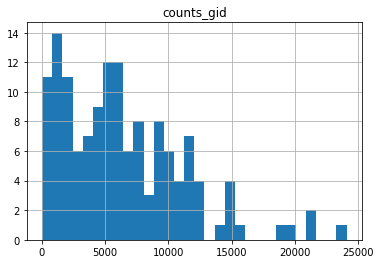

In [200]:
grains4.hist('counts_gid',bins=30)

In [175]:
avg_atoms_surf=(grains4['counts_gid'].mean())/6
d=np.sqrt(4*avg_atoms_surf/(np.pi))
d

36.887863317410165

In [176]:
fgb=step.gbid.sum()
print(fgb)
fgb=(fgb/(1440000))
fgb

511435


0.35516319444444444

In [19]:
t=d-(np.sqrt(1-fgb))*d
t

4.976073455529328

In [20]:
t=d*(1-(np.cbrt(1-fgb)))
t

3.4526079262654954

**Finding a value for the bin size:**

1 nm is a sensible lower limit for grain size, from the data gathered through TEM. 

Molybdenum has a unit cell of 314 pm or .314 nm.

It has a molar volume of 9.33 cm^3/mol - 0.0155 nm^3/atom

Finding the corresponding size of a cluster of atoms in this simulation: 

In [21]:
vol_c=(np.pi*(1)**2.0)*.471
print(vol_c)
vol_c/0.0155

1.4796901398407925


95.46387998972854

In [22]:
vol_c=(np.pi*(1/2)**2.0)*.471
print(vol_c)
vol_c/0.0155

0.3699225349601981


23.865969997432135

In [23]:
vol_s=(4/3)*np.pi*(1)**3
print(vol_s)
vol_s/0.0155

4.1887902047863905


270.24452934105744

In [5]:
os.chdir('/Users/seanmascarenhas/Desktop/MoAu/MoAu2')

In [6]:
list_of_directories=[]
#basic loop for directory generation
os.chdir('/Volumes/Samsung USB/MoAu2/')
for i in range (50,950,50):
    for j in range(1,31):
         list_of_directories.append(os.path.join(os.getcwd(),'{}/{}'.format(i,j)))
len(list_of_directories)

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Samsung USB/MoAu2/'

In [7]:
list_of_directories=[]
paths=[]
for path, dirs,files in os.walk(os.getcwd()):
#      print(len(path))
     if len(path)>=46:
         paths.append(path)
list_of_directories=natsort.os_sorted(paths)
#print(paths)
print(len(paths))

540


In [111]:
mean_size_list = []
d_list = []
std_list = []
fgb_list = []
t_sqrt = []
t_cbrt = []
p_list = []
sf_list=[]
unit = .314
height_sim = 4


def diameter(g_count):
    """diameter calculated from the number of atoms in the surface"""
    return (np.sqrt(4 * g_count/(height_sim * np.pi))) * unit

def shapefactor(area,peri):
    """shape factor for the grains"""
    return ((4*np.pi*area*unit*unit)/(height_sim*peri**2))

for items in list_of_directories:
    os.chdir(items)
    print(os.getcwd())
    step = pd.read_csv('step100000.txt', delim_whitespace='True', skiprows=9,
                       names=['x', 'y', 'z', 'cid', 'gid', 'gbid', 'nid'])

    grains = step.loc[step.gbid == 0]
    grains2 = grains[grains.duplicated(subset=['gid'], keep=False)]
    grains3 = grains2.groupby(['gid']).agg(counts_gid=('gid', 'count'))
    grains4 = grains3.loc[grains3.counts_gid >= 216].copy()
    grains4['diameter'] = grains4['counts_gid'].apply(lambda x: diameter(x))
    grains4['perimeter'] = grains4['diameter'].apply(lambda x: perimeter(x))
    grains4['shapefactor'] = grains4[['counts_gid','perimeter']].apply(lambda x: shapefactor(*x),axis=1)
    sf_list.append(grains4.shapefactor.mean())
    p = (600 * 600 * unit * unit) / grains4.perimeter.sum()
    p_list.append(p)
    mean_size_list.append(grains4['counts_gid'].mean())
    std_list.append(grains4['counts_gid'].std())
    avg_atoms_surf = grains4['counts_gid'].mean()
    d = diameter(avg_atoms_surf)
    d_list.append(d)
    fgb = step.gbid.sum()
    fgb = (fgb / 1440000)
    fgb_list.append(fgb)
    t_sqrt.append(d - (np.sqrt(1 - fgb)) * d)
    t_cbrt.append(d * (1 - (np.cbrt(1 - fgb))))


/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/1
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/2
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/3
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/4
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/5
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/6
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/7
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/8
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/9
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/10
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/11
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/12
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/13
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/14
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/15
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/16
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/17
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/18
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/19
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/20
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/21
/

In [26]:
t_sqrt_1=np.array_split((t_sqrt), 18)
len(t_sqrt)


def chunks(lst, n):
    return [lst[x:x+n] for x in range(0, len(lst), n)]
        
t_sqrt_1=[t_sqrt[x:x+30] for x in range(0, len(t_sqrt), 30)]
len(t_sqrt_1)==len(chunks(t_sqrt,30))

True

In [119]:
f_twist=[]
for num1, num2 in zip(fgb_list, p_list):
	f_twist.append(num1 * num2)

it makes sense that I need to multiply the total area by the grain boundary fraction 

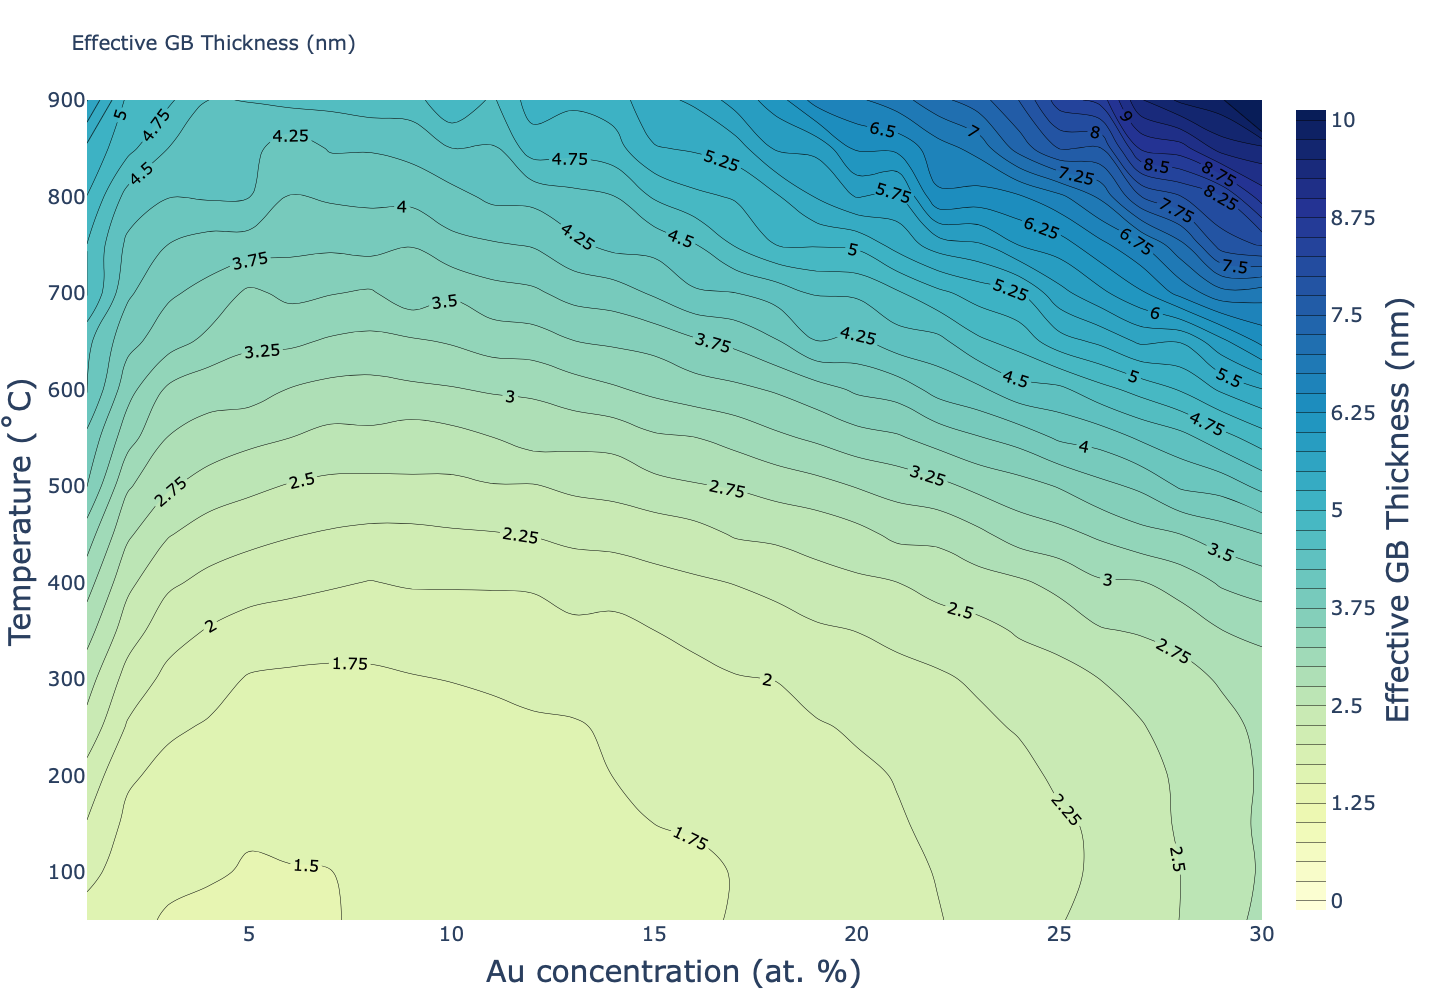

In [233]:
fig = go.FigureWidget(data =
    go.Contour(
        z=chunks(p_list,30),
        y=np.array(range (50,950,50)),
        x=np.array(range (1,31)),
        colorscale="ylgnbu",
         colorbar=dict(
             title='Effective GB Thickness (nm)',
             title_font_size=30,
             tickfont_size=20,
             titleside='right'
            )
        
        ,contours=dict(
            start=0,
            end=10,
            size=.25,
            showlabels = True, # show labels on contours
            labelfont = dict( # label font properties
                size = 16,
                color = 'black',
            )),
#             contours_coloring='heatmap'
    ))
fig.update_layout(title_text='Effective GB Thickness (nm)',
                 xaxis_title='Au concentration (at. %)',
                 yaxis_title='Temperature (˚C)',
                 title=dict(font_size=20))
fig.update_xaxes(title=dict(font_size=30),tickfont_size=20)
fig.update_yaxes(title=dict(font_size=30),tickfont_size=20)

fig.update_layout(
    autosize=False,
    width=1200,
    height=1000,
#     margin=dict(
#         l=50,
#         r=50,
#         b=100,
#         t=100,
#         pad=4
#     ),
#     paper_bgcolor="LightSteelBlue",
)

fig.show()

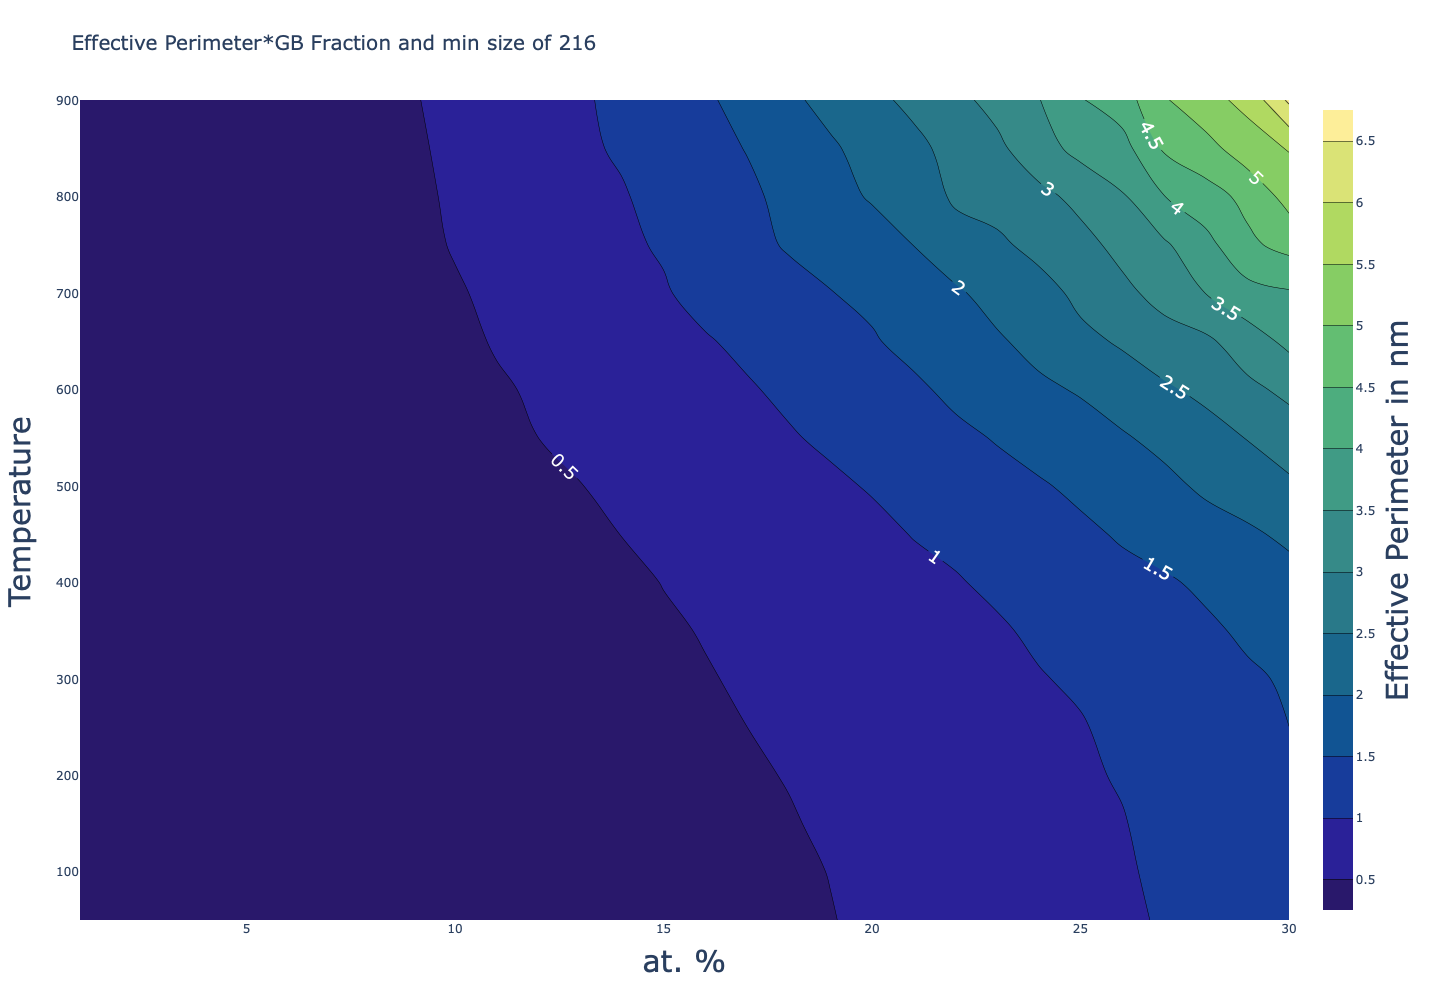

In [121]:
fig = go.FigureWidget(data =
    go.Contour(
        z=chunks(f_twist,30),
        y=np.array(range (50,950,50)),
        x=np.array(range (1,31)),
        colorscale="haline",
         colorbar=dict(
             title='Effective Perimeter in nm',
             title_font_size=30,
            titleside='right',
            )
        
        ,contours=dict(
#             start=0,
#             end=70,
#             size=2.5,
            showlabels = True, # show labels on contours
            labelfont = dict( # label font properties
                size = 18,
                color = 'white',
            )),
#         contours_coloring='heatmap'
    ))
fig.update_layout(title_text='Effective Perimeter*GB Fraction and min size of 216',
                 xaxis_title='at. %',
                 yaxis_title='Temperature',
                 title=dict(font_size=20))
fig.update_xaxes(title=dict(font_size=30))
fig.update_yaxes(title=dict(font_size=30)) 
fig.update_layout(
    autosize=False,
    width=1200,
    height=1000,
#     margin=dict(
#         l=50,
#         r=50,
#         b=100,
#         t=100,
#         pad=4
#     ),
#     paper_bgcolor="LightSteelBlue",
)

fig.show()

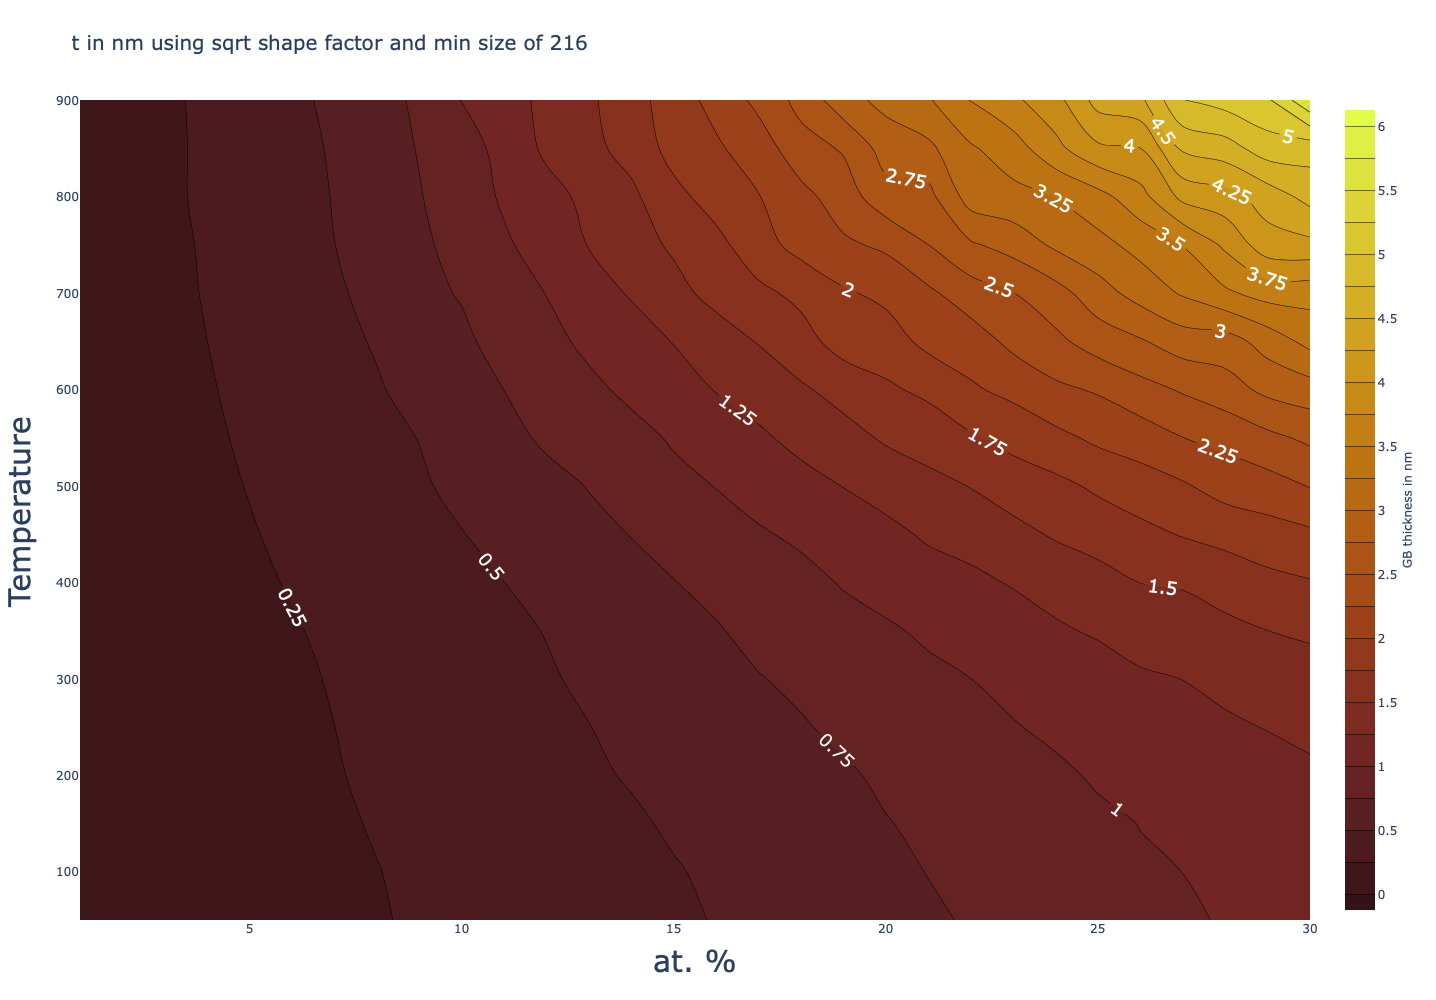

In [35]:


fig = go.FigureWidget(data =
    go.Contour(
        z=chunks(t_sqrt,30),
        y=np.array(range (50,950,50)),
        x=np.array(range (1,31)),
        colorscale="solar",
         colorbar=dict(
             title='GB thickness in nm', #dict(font_size=15),
            titleside='right',
            )
        
        ,contours=dict(
            start=0,
            end=6,
            size=.25,
            showlabels = True, # show labels on contours
            labelfont = dict( # label font properties
                size = 18,
                color = 'white',
            )),
#         contours_coloring='heatmap'
    ))
fig.update_layout(title_text='t in nm using sqrt shape factor and min size of 216',
                 xaxis_title='at. %',
                 yaxis_title='Temperature',
                 title=dict(font_size=20))
fig.update_xaxes(title=dict(font_size=30))
fig.update_yaxes(title=dict(font_size=30)) 
fig.update_layout(
    autosize=False,
    width=1200,
    height=1000,
#     margin=dict(
#         l=50,
#         r=50,
#         b=100,
#         t=100,
#         pad=4
#     ),
#     paper_bgcolor="LightSteelBlue",
)

fig.show()

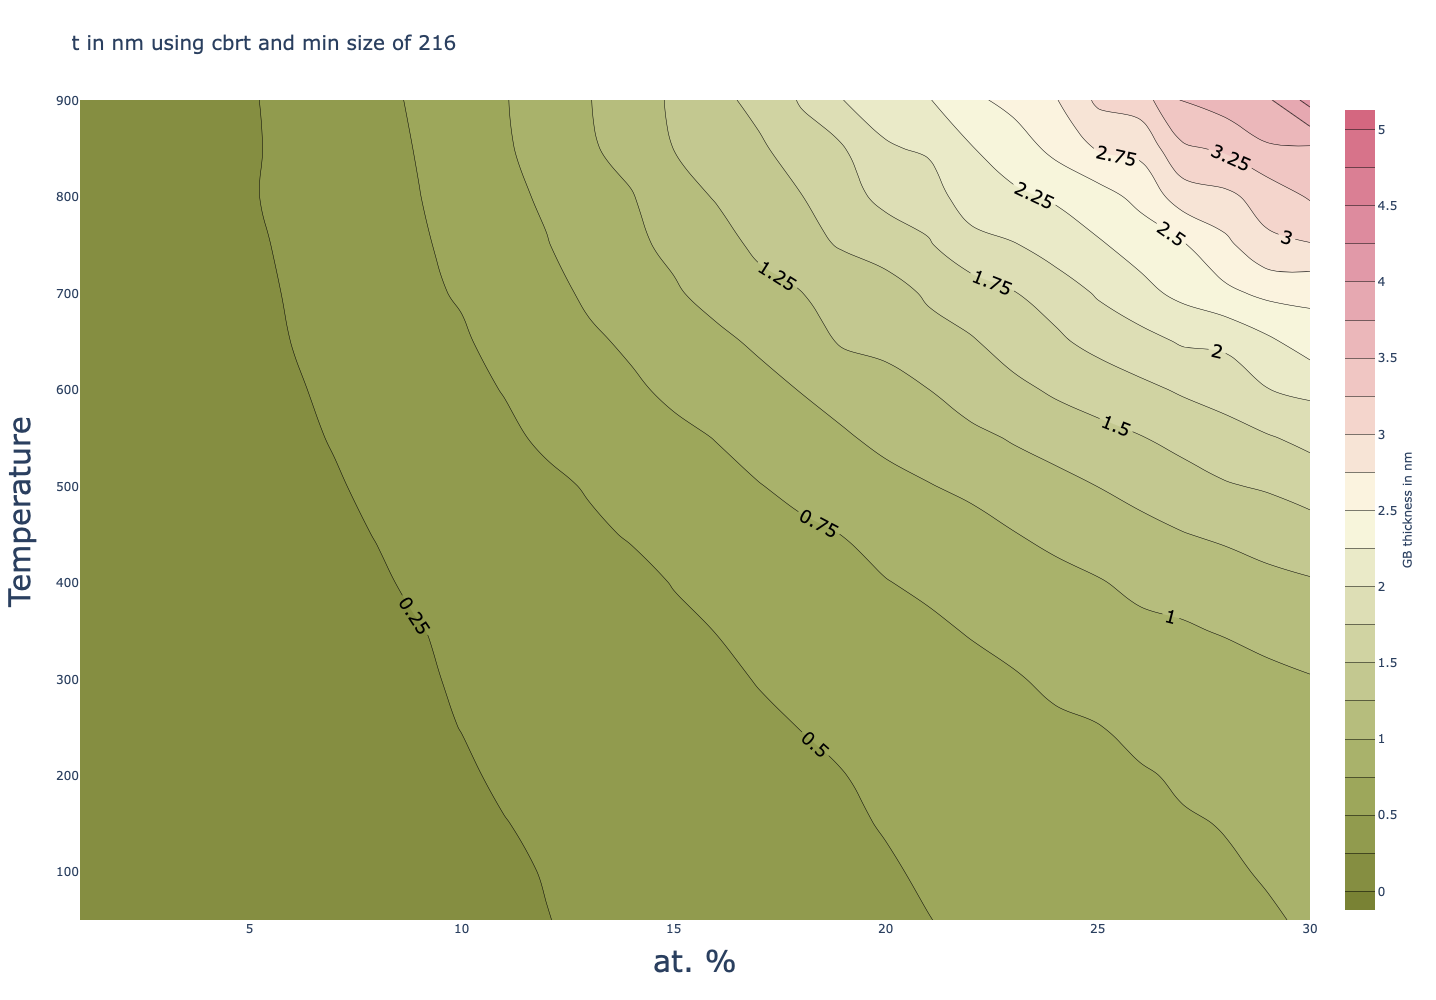

In [36]:
fig = go.FigureWidget(data =
    go.Contour(
        z=chunks(t_cbrt,30),
        y=np.array(range (50,950,50)),
        x=np.array(range (1,31)),
        colorscale="armyrose",
         colorbar=dict(
            title='GB thickness in nm', # title here
            titleside='right'
            )
        ,contours=dict(
            start=0,
            end=5,
            size=.25,
            showlabels = True, # show labels on contours
            labelfont = dict( # label font properties
                size = 18,
                color = 'black',
            )),
#         contours_coloring='heatmap'
    ))
fig.update_layout(title_text='t in nm using cbrt and min size of 216',
                 xaxis_title='at. %',
                 yaxis_title='Temperature',
                  title=dict(font_size=20))
fig.update_xaxes(title=dict(font_size=30))
fig.update_yaxes(title=dict(font_size=30)) 
fig.update_layout(
    autosize=False,
    width=1200,
    height=1000,
)

fig.show()

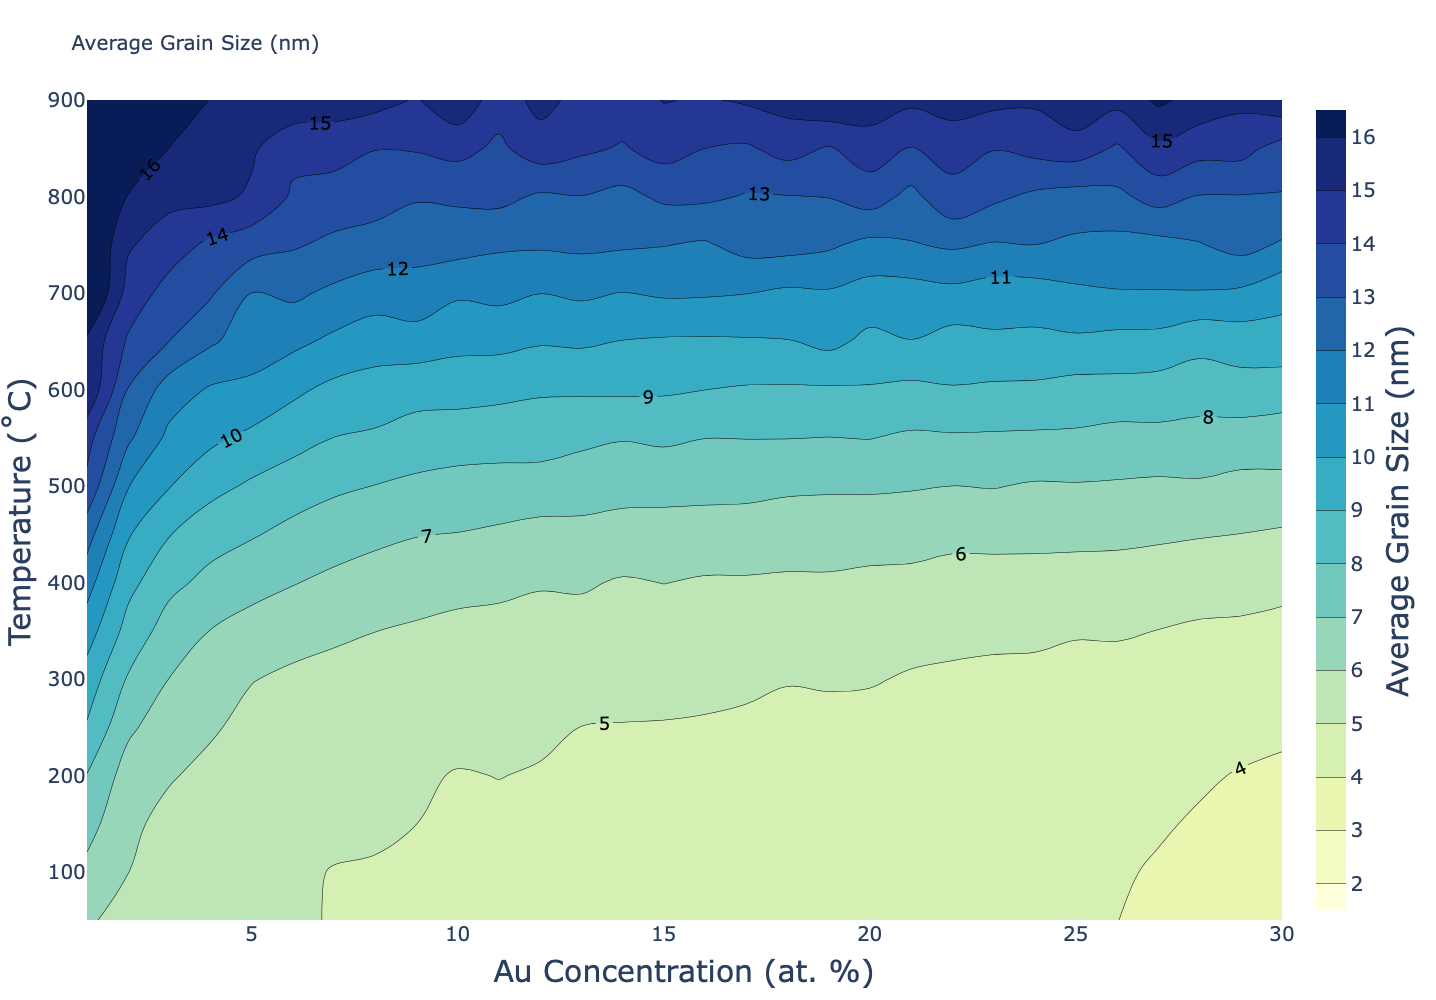

In [236]:
fig = go.FigureWidget(data =
    go.Contour(
        z=chunks(d_list,30),
        y=np.array(range (50,950,50)),
        x=np.array(range (1,31)),
        colorscale="ylgnbu",
         colorbar=dict(
            title='Average Grain Size (nm)', # title here
            titleside='right',
            title_font_size=30,
            tickfont_size = 20,
            )
        ,contours=dict(
            start=2,
            end=16,
            size=1,
            showlabels = True, # show labels on contours
            labelfont = dict( # label font properties
                size = 18,
                #color = 'white',
            )),
#         contours_coloring='heatmap'
    ))
fig.update_layout(title_text='Average Grain Size (nm)',
                 xaxis_title='Au Concentration (at. %)',
                 yaxis_title='Temperature (˚C)',
                  title=dict(font_size=20))
fig.update_xaxes(title=dict(font_size=30),tickfont_size=20)
fig.update_yaxes(title=dict(font_size=30),tickfont_size=20) 
fig.update_layout(
    autosize=False,
    width=1200,
    height=1000,
#     margin=dict(
#         l=50,
#         r=50,
#         b=100,
#         t=100,
#         pad=4
#     ),
#     paper_bgcolor="LightSteelBlue",
)

fig.show()

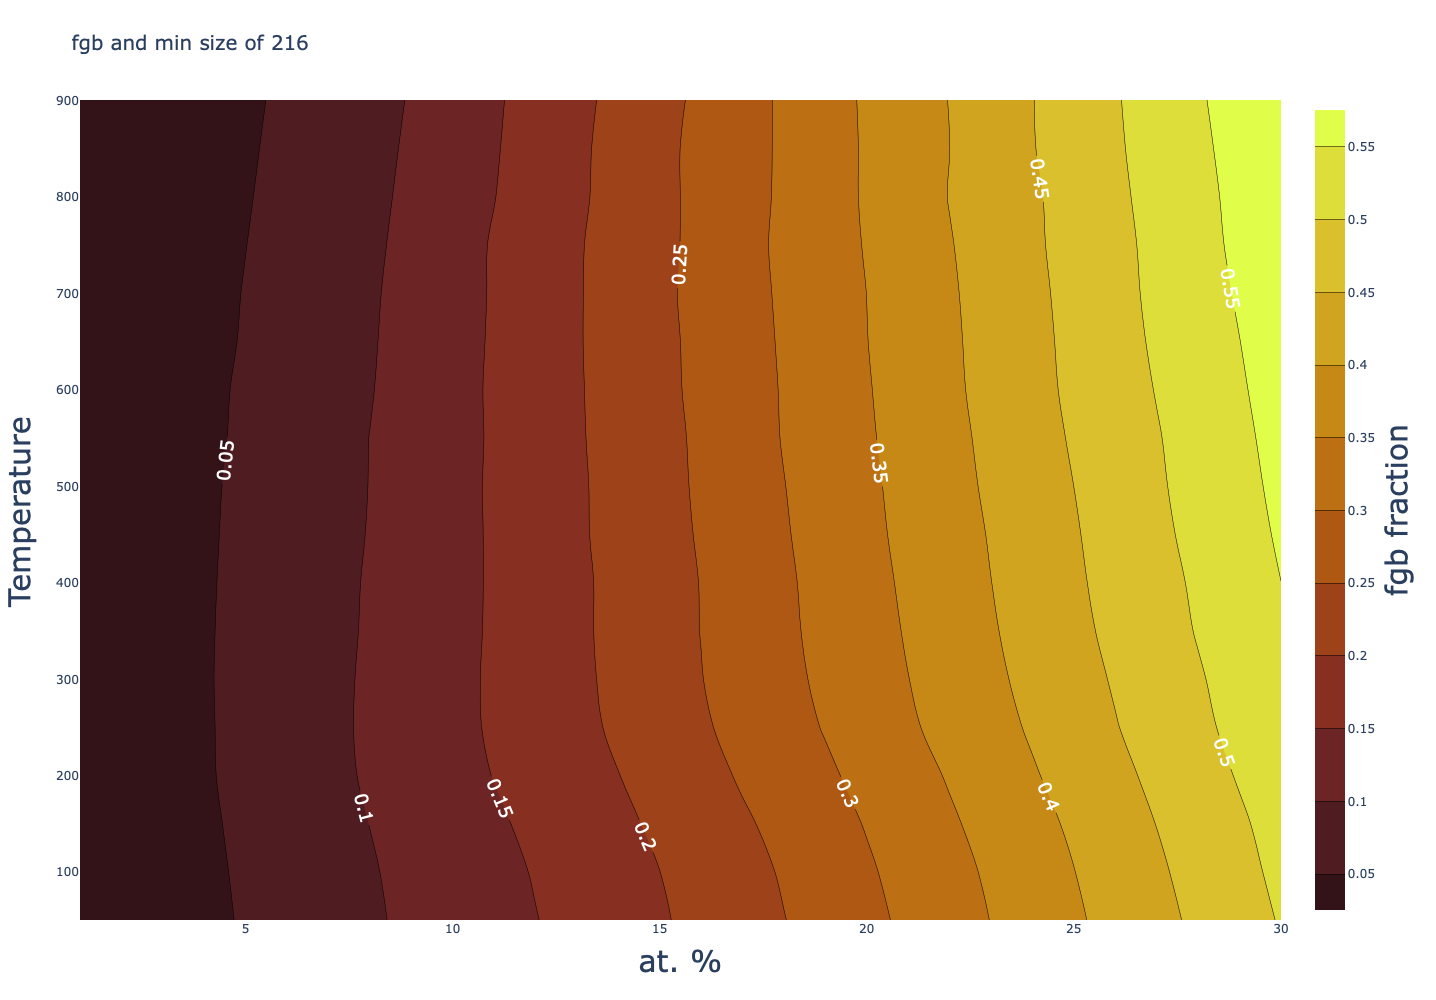

In [50]:
fig = go.FigureWidget(data =
    go.Contour(
        z=chunks(fgb_list,30),
        y=np.array(range (50,950,50)),
        x=np.array(range (1,31)),
        colorscale="solar",
         colorbar=dict(
             title='fgb fraction',
             title_font_size=30,
            titleside='right',
            )
        
        ,contours=dict(
#             start=0,
#             end=70,
#             size=2.5,
            showlabels = True, # show labels on contours
            labelfont = dict( # label font properties
                size = 18,
                color = 'white',
            )),
#         contours_coloring='heatmap'
    ))
fig.update_layout(title_text='fgb and min size of 216',
                 xaxis_title='at. %',
                 yaxis_title='Temperature',
                 title=dict(font_size=20))
fig.update_xaxes(title=dict(font_size=30))
fig.update_yaxes(title=dict(font_size=30)) 
fig.update_layout(
    autosize=False,
    width=1200,
    height=1000,
#     margin=dict(
#         l=50,
#         r=50,
#         b=100,
#         t=100,
#         pad=4
#     ),
#     paper_bgcolor="LightSteelBlue",
)

fig.show()

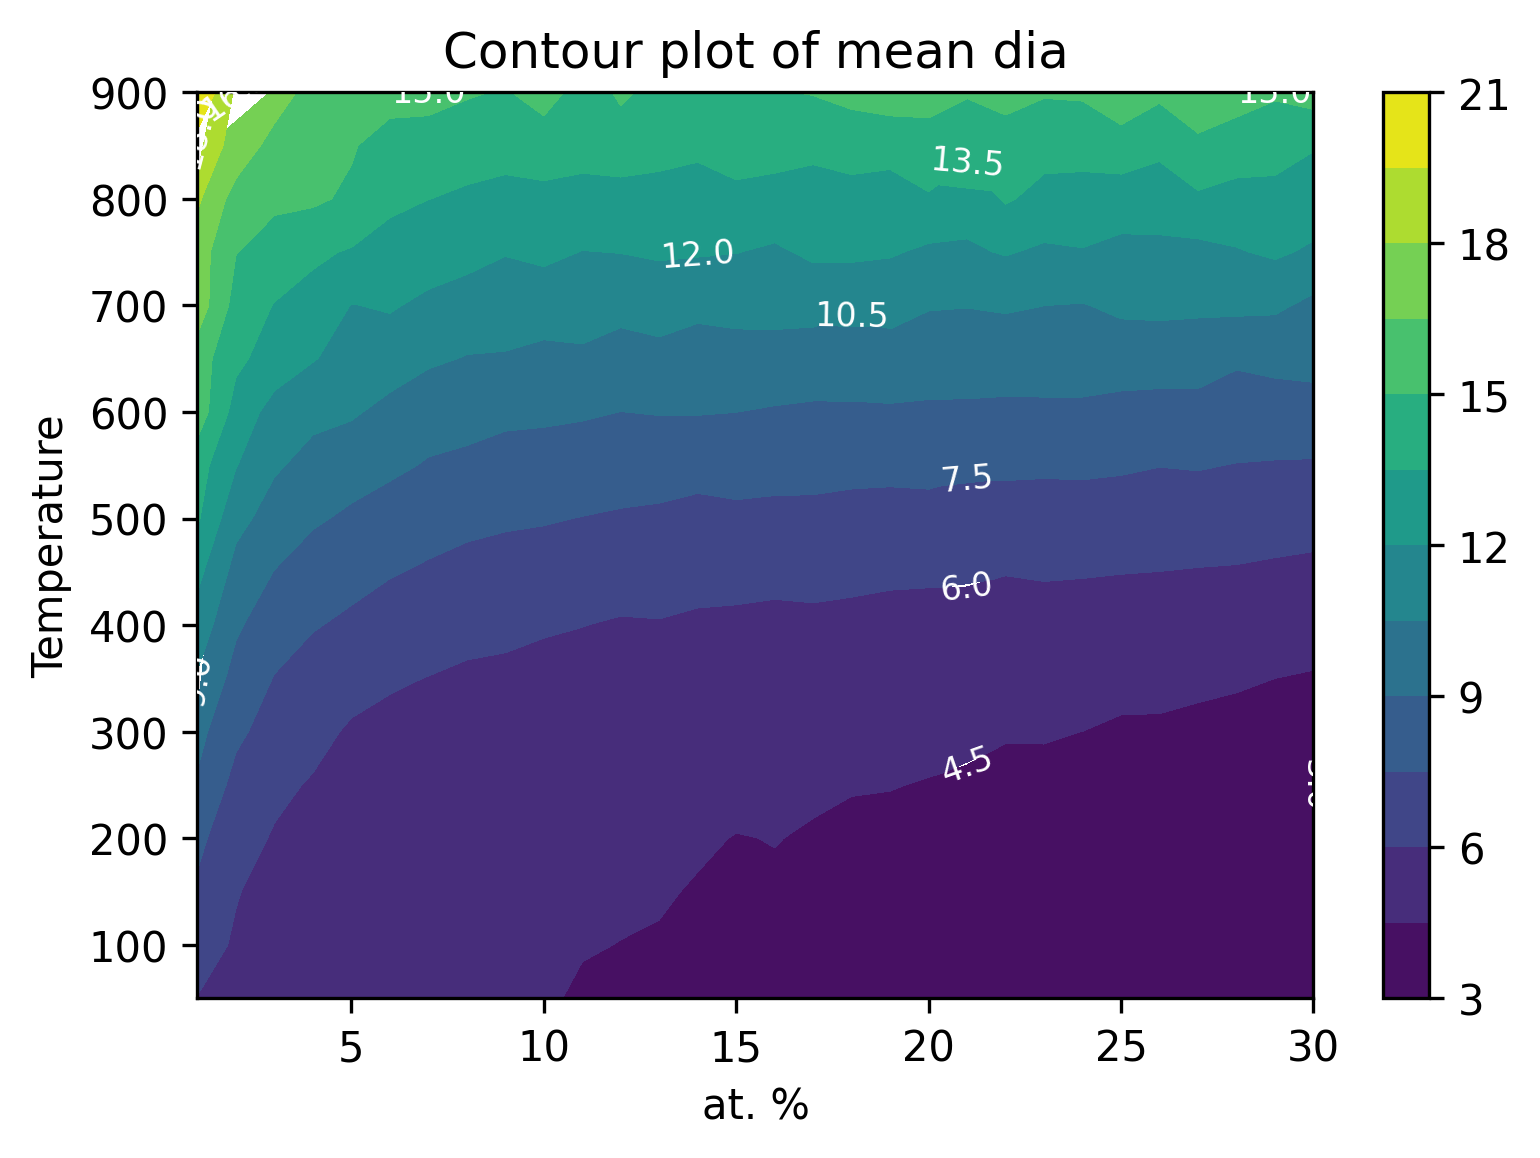

In [48]:
Y=range (50,950,50)
X=range (1,31)
Z=chunks(d_list,30)
# plt.figure(dpi=300)
fig, ax = plt.subplots(dpi=300)
CS = ax.contourf(X, Y, Z,15)
ax.clabel(CS, inline=True, fontsize=8,colors='white')
plt.title('Contour plot of mean dia')
plt.xlabel('at. %')
plt.ylabel('Temperature')
fig.colorbar(CS)
plt.show()

In [110]:
Z=t_sqrt_1
# plt.figure(dpi=300)
fig, ax = plt.subplots(dpi=300)
CS = ax.contourf(X, Y, Z,20)
#ax.clabel(CS, inline=True, fontsize=10)
plt.title('Contour plot of t, sqrt')
plt.xlabel('at. %')
plt.ylabel('Temperature')
fig.colorbar(CS)
plt.show()

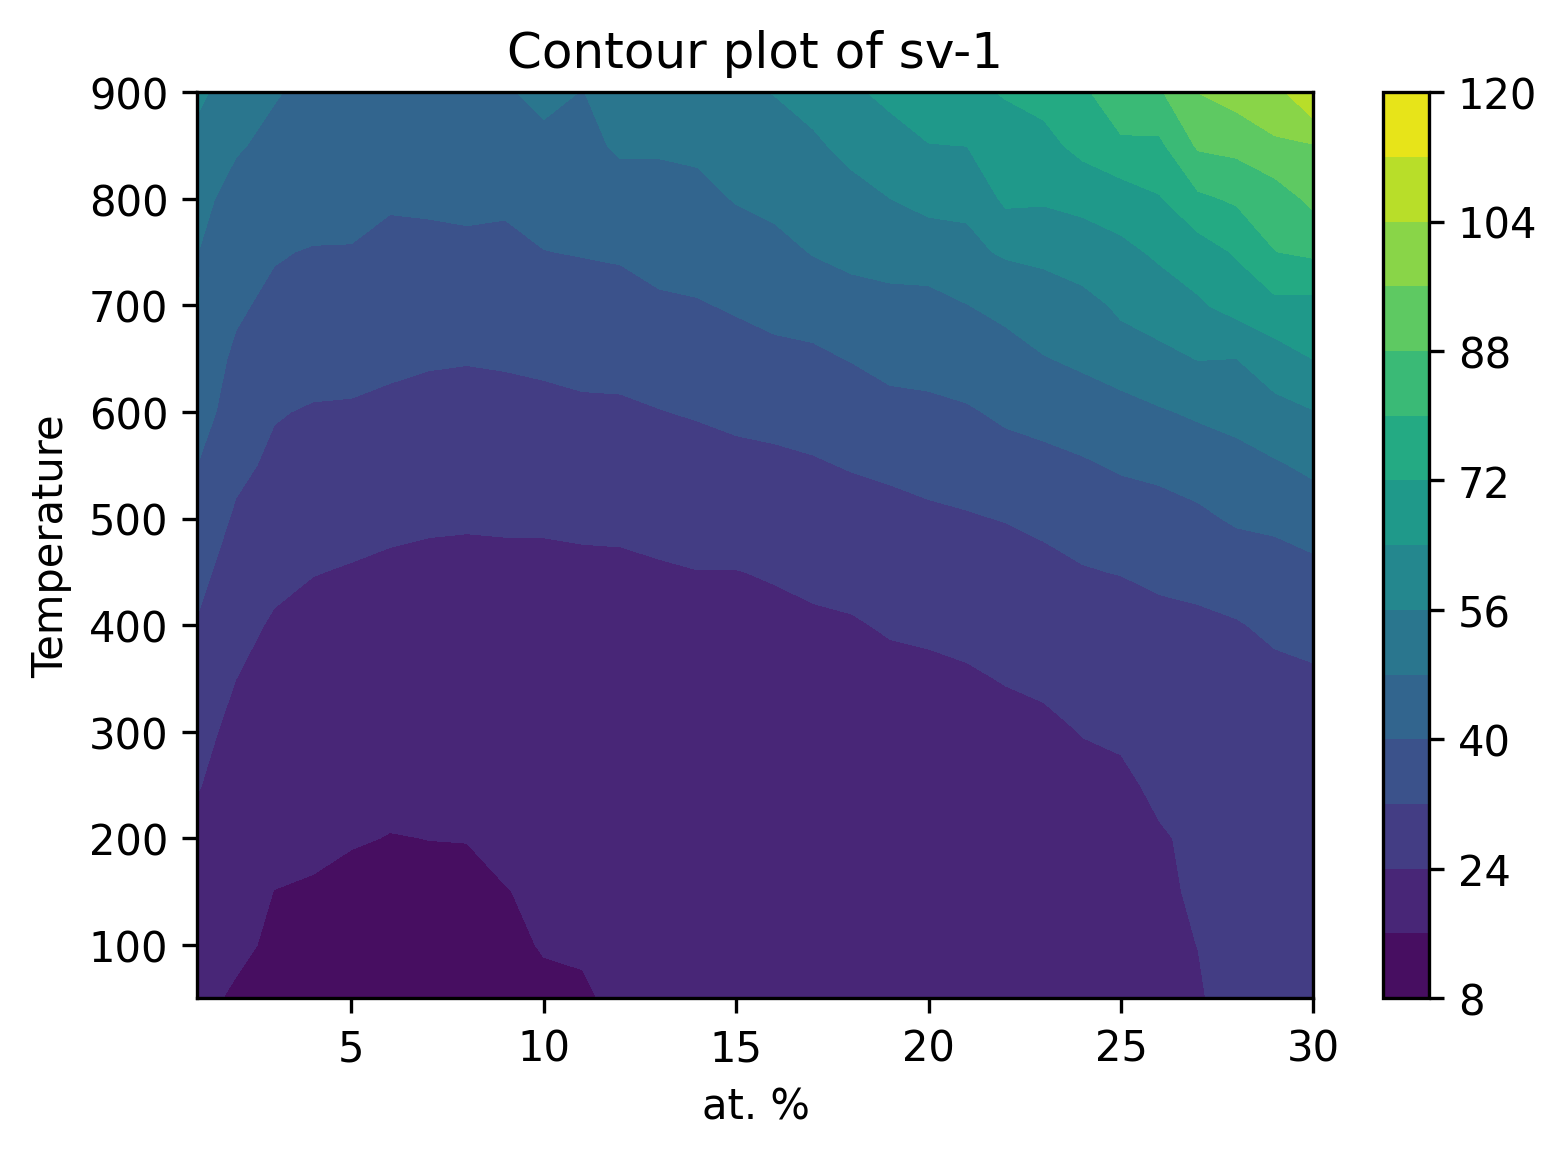

In [94]:
Y=range (50,950,50)
X=range (1,31)
Z=chunks(p_list,30)
# plt.figure(dpi=300)
fig, ax = plt.subplots(dpi=300)
CS = ax.contourf(X, Y, Z,15)
#ax.clabel(CS, inline=True, fontsize=8,colors='white')
plt.title('Contour plot of sv-1')
plt.xlabel('at. %')
plt.ylabel('Temperature')
fig.colorbar(CS)
plt.show()

In [112]:
Y=range (50,950,50)
X=range (1,31)
Z=chunks(fgb_list,30)
# plt.figure(dpi=300)
fig, ax = plt.subplots(dpi=300)
CS = ax.contourf(X, Y, Z)
#ax.clabel(CS, inline=True, fontsize=8,colors='white')
plt.title('Contour plot of fgb')
plt.xlabel('at. %')
plt.ylabel('Temperature')
fig.colorbar(CS)
plt.show()

In [113]:
Y=range (50,950,50)
X=range (1,31)
Z=chunks(mean_size_list,30)
# plt.figure(dpi=300)
fig, ax = plt.subplots()
CS = ax.contourf(X, Y, Z,20)
ax.clabel(CS, inline=True, fontsize=8,colors='white')
plt.title('Contour plot of mean size')
plt.xlabel('at. %')
plt.ylabel('Temperature')
fig.colorbar(CS)
plt.show()

**Version 2, minimum cluster size of 96**

In [118]:
mean_size_list1 = []
d_list1 = []
std_list1 = []
fgb_list1 = []
t_sqrt1 = []
t_cbrt1 = []
p_list1 = []
sf_list1=[]
unit = .314
height_sim = 4


for items in list_of_directories:
    os.chdir(items)
    print(os.getcwd())
    step = pd.read_csv('step100000.txt', delim_whitespace='True', skiprows=9,
                       names=['x', 'y', 'z', 'cid', 'gid', 'gbid', 'nid'])

    grains = step.loc[step.gbid == 0]
    grains2 = grains[grains.duplicated(subset=['gid'], keep=False)]
    grains3 = grains2.groupby(['gid']).agg(counts_gid=('gid', 'count'))
    grains4 = grains3.loc[grains3.counts_gid >= 96].copy()
    grains4['diameter'] = grains4['counts_gid'].apply(lambda x: diameter(x))
    grains4['perimeter'] = grains4['diameter'].apply(lambda x: perimeter(x))
    grains4['shapefactor'] = grains4[['counts_gid','perimeter']].apply(lambda x: shapefactor(*x),axis=1)
    sf_list1.append(grains4.shapefactor.mean())
    p = (600 * 600*unit*unit) / grains4.perimeter.sum()
    p_list1.append(p)
    mean_size_list1.append(grains4['counts_gid'].mean())
    std_list1.append(grains4['counts_gid'].std())
    avg_atoms_surf = grains4['counts_gid'].mean()
    d = diameter(avg_atoms_surf)
    d_list1.append(d)
    fgb = step.gbid.sum()
    fgb = (fgb / 1440000)
    fgb_list1.append(fgb)
    t_sqrt1.append(d - (np.sqrt(1 - fgb)) * d)
    t_cbrt1.append(d * (1 - (np.cbrt(1 - fgb))))

/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/1
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/2
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/3
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/4
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/5
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/6
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/7
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/8
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/9
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/10
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/11
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/12
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/13
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/14
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/15
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/16
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/17
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/18
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/19
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/20
/Users/seanmascarenhas/Desktop/MoAu/MoAu2/50/21
/

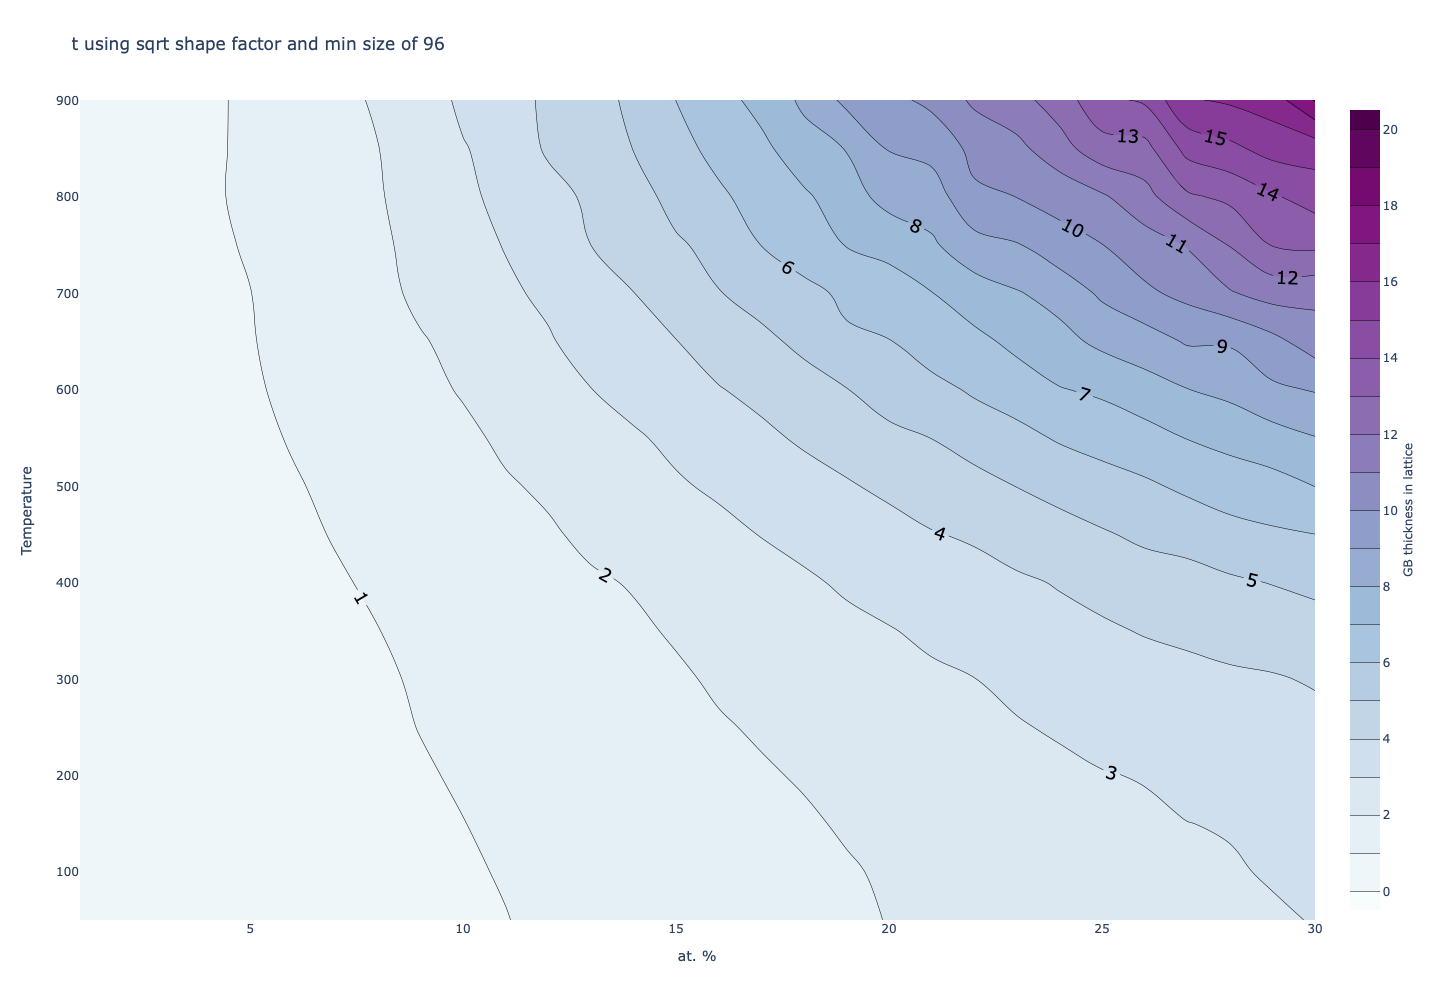

In [52]:
fig = go.FigureWidget(data =
    go.Contour(
        z=chunks(t_sqrt1,30),
        y=np.array(range (50,950,50)),
        x=np.array(range (1,31)),
        colorscale="bupu",
         colorbar=dict(
            title='GB thickness in lattice', # title here
            titleside='right'
            )
        ,contours=dict(
            start=0,
            end=20,
            size=1,
            showlabels = True, # show labels on contours
            labelfont = dict( # label font properties
                size = 18,
                color = 'black',
            )),
#         contours_coloring='heatmap'
    ))
fig.update_layout(title_text='t using sqrt shape factor and min size of 96',
                 xaxis_title='at. %',
                 yaxis_title='Temperature')
fig.update_layout(
    autosize=False,
    width=1200,
    height=1000,
)

fig.show()

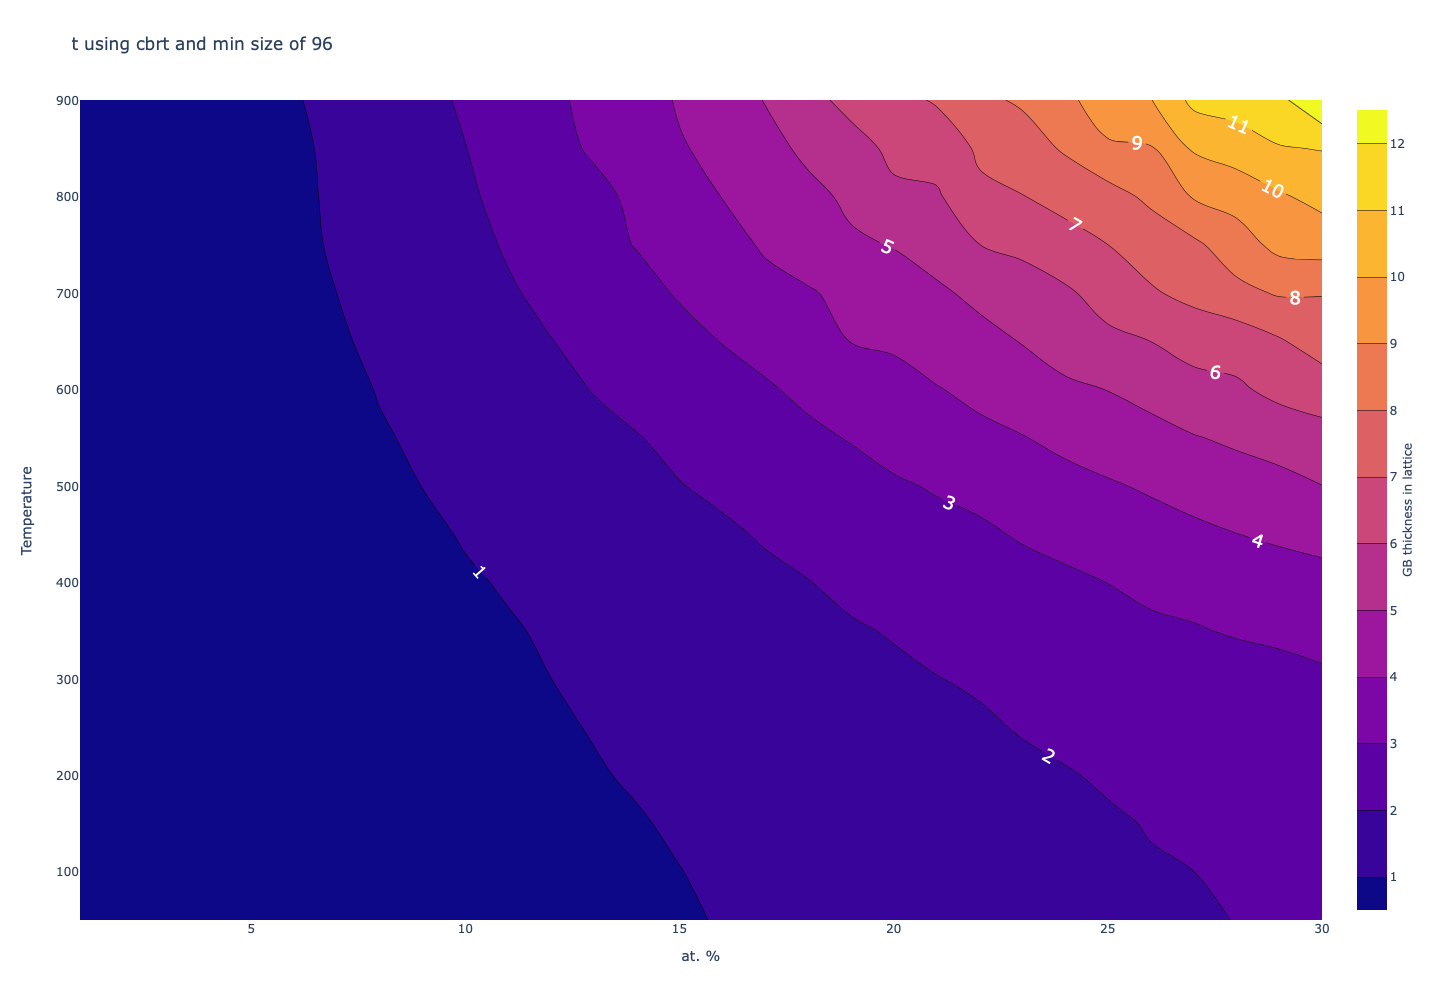

In [51]:
fig = go.FigureWidget(data =
    go.Contour(
        z=chunks(t_cbrt1,30),
        y=np.array(range (50,950,50)),
        x=np.array(range (1,31)),
        colorscale="plasma",
         colorbar=dict(
            title='GB thickness in lattice', # title here
            titleside='right'
            )
        ,contours=dict(
#             start=0,
#             end=5,
#              size=.25,
            showlabels = True, # show labels on contours
            labelfont = dict( # label font properties
                size = 18,
                color = 'white',
            )),
#         contours_coloring='heatmap'
    ))
fig.update_layout(title_text='t using cbrt and min size of 96',
                 xaxis_title='at. %',
                 yaxis_title='Temperature')
fig.update_layout(
    autosize=False,
    width=1200,
    height=1000,
)

fig.show()

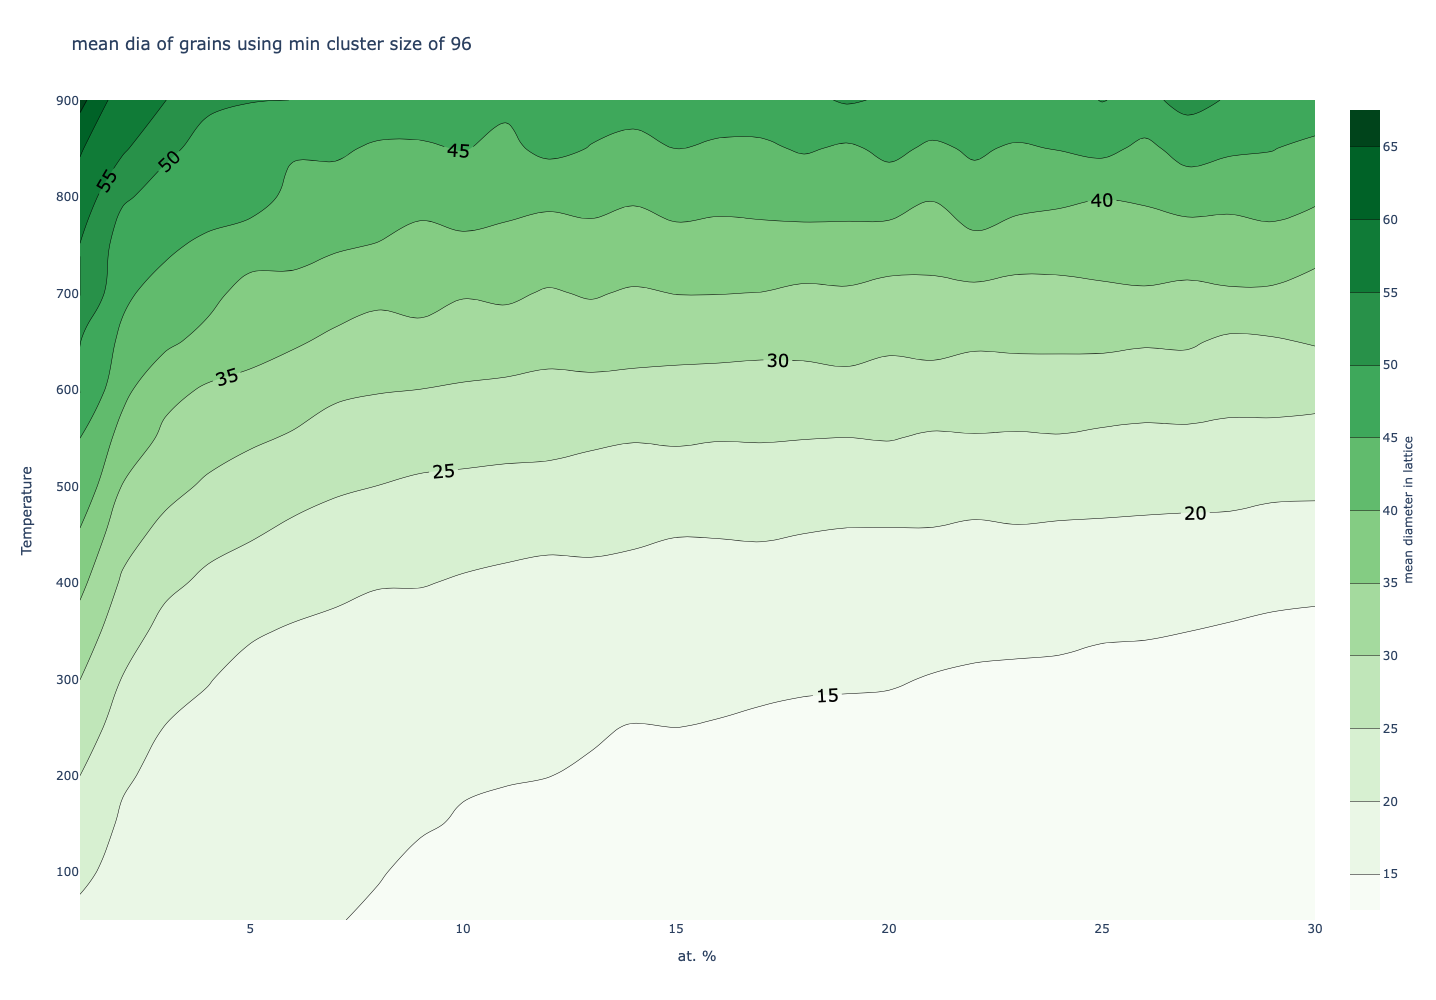

In [50]:
fig = go.FigureWidget(data =
    go.Contour(
        z=chunks(d_list1,30),
        y=np.array(range (50,950,50)),
        x=np.array(range (1,31)),
        colorscale="greens",
         colorbar=dict(
            title='mean diameter in lattice', # title here
            titleside='right'
            )
        ,contours=dict(
#             start=0,
#             end=20,
#             size=1,
            showlabels = True, # show labels on contours
            labelfont = dict( # label font properties
                size = 18,
                color = 'black',
            )),
#         contours_coloring='heatmap'
    ))
fig.update_layout(title_text='mean dia of grains using min cluster size of 96',
                 xaxis_title='at. %',
                 yaxis_title='Temperature')
fig.update_layout(
    autosize=False,
    width=1200,
    height=1000,
)

fig.show()

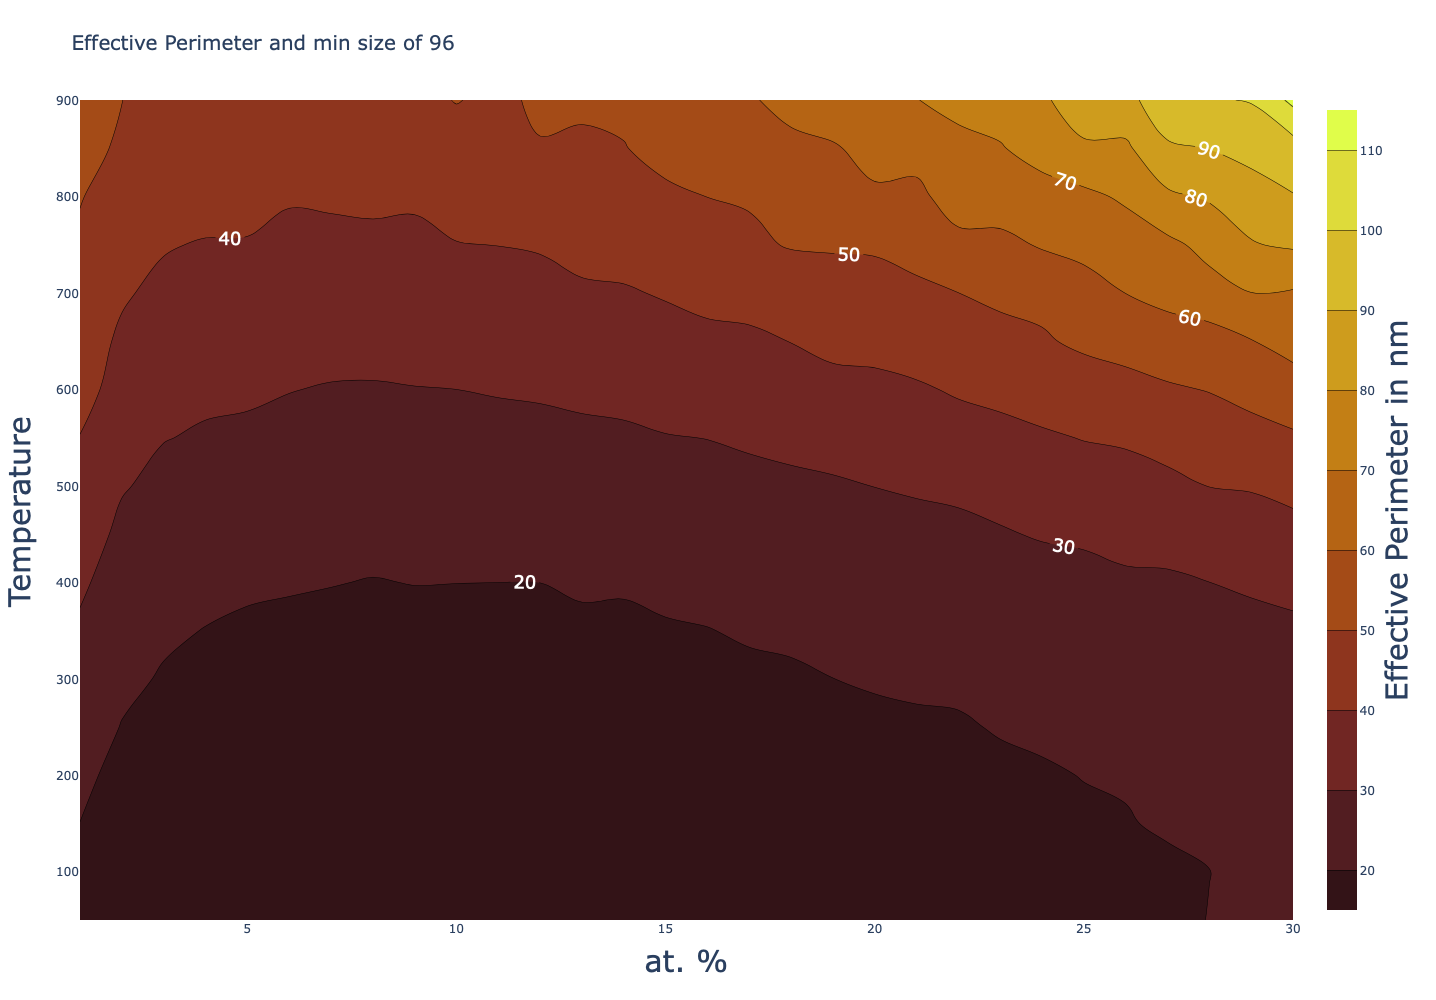

In [80]:
fig = go.FigureWidget(data =
    go.Contour(
        z=chunks(p_list1,30),
        y=np.array(range (50,950,50)),
        x=np.array(range (1,31)),
        colorscale="solar",
         colorbar=dict(
             title='Effective Perimeter in nm',
             title_font_size=30,
            titleside='right',
            )
        
        ,contours=dict(
#             start=0,
#             end=6,
#             size=.25,
            showlabels = True, # show labels on contours
            labelfont = dict( # label font properties
                size = 18,
                color = 'white',
            )),
#         contours_coloring='heatmap'
    ))
fig.update_layout(title_text='Effective Perimeter and min size of 96',
                 xaxis_title='at. %',
                 yaxis_title='Temperature',
                 title=dict(font_size=20))
fig.update_xaxes(title=dict(font_size=30))
fig.update_yaxes(title=dict(font_size=30)) 
fig.update_layout(
    autosize=False,
    width=1200,
    height=1000,
#     margin=dict(
#         l=50,
#         r=50,
#         b=100,
#         t=100,
#         pad=4
#     ),
#     paper_bgcolor="LightSteelBlue",
)

fig.show()